In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, mpld3
import os
import fnmatch
import csv
import pickle
import warnings
import torch
import time

warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

### Create architecture

In [89]:
def make_model(inputs, n_outputs):

    hidden_layer_1 = tf.layers.dense(inputs, 10, activation=tf.nn.leaky_relu)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 15, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 10, activation=tf.nn.sigmoid)
    #hidden_layer_4 = tf.layers.dense(hidden_layer_3, 5, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dropout(hidden_layer_3, 0.05)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)

    return output



### Prepare data for training

Cost function: $\chi^2 = 1/N \sum (y - y_{pred})^2 / \sigma^2$ \
Optimizer: AdamOptimizer, $\eta = 0.02$\

Training points are generated by Monte Carlo sampling; for the set of training points $[dE, D_i, \sigma_i]$, a set of MC training points is generated by adding a stochastic noise signal on top of the the data with a std equal to the corresponding error on that point. 

- **train_x**: $[dE, t_{exp}]$
- **train_y**: $D_i$ + rand.norm(0, $\sigma_i$)

Repetitive training of the NN (number of repetitions = $N_{rep}$) on each set of MC pseudo data yields a prediction that is distributed with a mean and std corresponding to the mean and error of the original training set. 


In [90]:
tf.reset_default_graph()
from copy import copy
from sklearn.model_selection import train_test_split

x = tf.placeholder("float", [None, 3])
y = tf.placeholder("float", [None, 1])
sigma = tf.placeholder("float", [None, 1])

df_train_full = pd.read_csv('Data/Apr/training_merged_3.csv', header=0)
df_train, df_test = train_test_split(df_train_full, test_size=0.15)

train_x = np.array(df_train[['x', 'time', 'energy']].to_numpy())
N_train = len(train_x[:,0])
train_y = np.copy(df_train['y']).reshape(N_train,1)
train_sigma = np.copy(df_train['sigma']).reshape(N_train,1)

test_x = np.array(df_test[['x', 'time', 'energy']].to_numpy())
N_test = len(test_x[:,0])
test_y = np.copy(df_test['y']).reshape(N_test,1)
test_sigma = np.copy(df_test['sigma']).reshape(N_test,1)


predictions = make_model(x,1)




## Set a restriction for the minimum relative error

In [91]:
relative_error = np.divide(train_sigma, train_y)
treshold = 0.001
treshold_error_index = np.where(relative_error > treshold)[0]
train_x, train_y, train_sigma = train_x[treshold_error_index], train_y[treshold_error_index], train_sigma[treshold_error_index]
N_train = len(train_x)

relative_error = np.divide(test_sigma, test_y)
treshold_error_index = np.where(relative_error > treshold)[0]
test_x, test_y, test_sigma = test_x[treshold_error_index], test_y[treshold_error_index], test_sigma[treshold_error_index]
N_test = len(test_x)

## Create MC replicas

In [92]:
### Create array of Nrep training samples
Nrep = 1000
#pbar = tqdm(total=Nrep)
train_y_reps = np.zeros(shape=(N_train, Nrep))
test_y_reps = np.zeros(shape=(N_test, Nrep))
i=0
while i < Nrep:
    train_rep = np.random.normal(0, train_sigma)
    test_rep = np.random.normal(0, test_sigma)
    train_y_reps[:,i] = (train_y + train_rep).reshape(N_train)
    test_y_reps[:,i] = (test_y + test_rep).reshape(N_test)
    i+=1 
train_y_reps[train_y_reps < .1] = .1    
test_y_reps[test_y_reps < .1] = .1
std_reps = np.std(train_y_reps, axis=1)
mean_reps = np.mean(train_y_reps, axis=1)

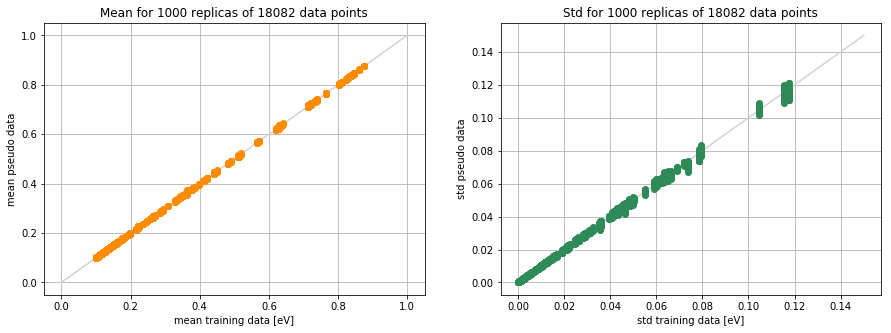

In [93]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title('Mean for %(Nrep)s replicas of %(N_train)s data points' % {"Nrep": Nrep, "N_train": N_train})
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), color='lightgrey')
plt.plot(train_y, mean_reps, 'o', color = 'darkorange', label = 'Predictions pseudodata')
plt.grid(True)
plt.xlabel(r'mean training data [eV]')
plt.ylabel(r'mean pseudo data')

plt.subplot(122)
plt.grid(True)
plt.title('Std for %(Nrep)s replicas of %(N_train)s data points' % {"Nrep": Nrep, "N_train": N_train})
plt.plot(np.linspace(0,0.15,10), np.linspace(0,0.15,10), color='lightgrey')
plt.plot(train_sigma, std_reps, 'o', color='seagreen', label = 'Predictions pseudodata')
plt.xlabel(r'std training data [eV]')
plt.ylabel(r'std pseudo data')

plt.show()

In [139]:
## Beam energy interpolation
interpol_energy = .6
index10, index100 = np.where(train_x[:,1] == .1), np.where(train_x[:,1] == 1) #select 10 or 100 ms data
predict_x_10, predict_x_100  = np.where((train_x==2), interpol_energy, train_x) , np.where((train_x==2), interpol_energy, train_x) # place 140 meV
predict_x = predict_x_100[index100]
indexenergy = np.where(predict_x[:,2] == interpol_energy)
predict_x = predict_x[indexenergy]
predict_x[:,0] = np.interp(predict_x[:,0], (predict_x[:,0].min(), predict_x[:,0].max()), (-1, 2)) #change x-range a bit

## Energy loss extrapolation
#predict_x = copy(train_x)
#predict_x[:,0] = np.interp(predict_x[:,0], (predict_x[:,0].min(), predict_x[:,0].max()), (-1, 2))
#print(predict_x.shape)


2.0


In [95]:
import time
from datetime import datetime

training_epochs = 30000
max_rising_epochs = 10000 #The amount of epochs the minimzer is allowed to overfit before it stops
display_step = 1000
chi_array = []

tic = time.time()

### Define cost and optimizer
cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
custom_cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="custom_cost_function")
eta = 3e-2
optimizer = tf.train.AdamOptimizer(learning_rate=eta, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(cost)

i = 0
Nrep = 20

while i < (Nrep):
    
    """Training data: train_y = D_i + rand.norm(0, sigma_i);
    use train_y = gaus_y + rand.norm(0, sigma_i) in case of Closure testing"""
    
    train_y = train_y_reps[:,i].reshape(N_train,1)
    test_y = test_y_reps[:,i].reshape(N_test,1)

    ### Train and validate
    prev_test_cost = 100
    prev_epoch=0
    avg_cost = 0.0

    array_train = []
    array_test = []
    
    print("Start training on", '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        

        for epoch in range(training_epochs):

            _, c = sess.run([optimizer, cost], 
                            feed_dict={
                                x: train_x,
                                y: train_y,
                                sigma: train_sigma
                            })
            avg_cost = c 

            test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})


            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
                array_train.append(avg_cost)
                array_test.append(test_cost)

            if test_cost >= prev_test_cost and epoch-prev_epoch >= max_rising_epochs:
                print(colored("\n The session stopped because of overfitting...","red"))
                print("Start overfitting at epoch:", '%04d' % (epoch), "| Validation cost =", "{:.9f}".format(test_cost), "| Train cost=", "{:.9f}".format(avg_cost))
                break

            elif test_cost < prev_test_cost:
                prev_test_cost = test_cost
                prev_epoch = epoch


        print("Optimization Finished!")
        predictions_values = sess.run(predictions, 
                            feed_dict={
                                x: train_x,
                                y: train_y 
                            }) 
        
        extrapolation = sess.run(predictions,
                            feed_dict={
                                x: predict_x
                            })
    
    sess.close()

    # save to csv file
    predictions_values = predictions_values.reshape(N_train,)
    toc = time.time()
    print("Elapsed time:", toc-tic)
    
    now = datetime.now()
  
    dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
    d_string = now.strftime("%d.%m.%Y")
    t_string = now.strftime("%H:%M:%S")

    #foot = np.array(seednumber)
    a = np.array(train_x[:,0])
    b = np.array(train_y)
    c = np.array(predictions_values)
    d = array_train
    e = array_test
    g = np.array(train_x[:,1])
    h = np.array(train_x[:,2])
    k1 = np.array(predict_x[:,0])
    k2 = np.array(predict_x[:,1])
    k3 = np.array(predict_x[:,2])
    l = np.array(extrapolation)
    
    chi_array.append(d[-1])

    best_chi = np.where(array_test == min(array_test))
    
    np.savetxt('Data/Results/%(date)s/xyp1p2_all_e%(epoch)s_round3_%(i)x.csv' % {"date": d_string, "epoch": training_epochs, "i": i }, list(zip(a,b,c,g,h)),  delimiter=',',  header="best iteration: %(p)s" % {"p": best_chi}, fmt='%f')
    np.savetxt('Data/Results/%(date)s/chi_all_e%(epoch)s_round3_%(i)x.csv' % {"date": d_string, "epoch": training_epochs, "i": i }, list(zip(d,e)),  delimiter=',',  header="best iteration: %(p)s" % {"p": best_chi}, fmt='%f')
    np.savetxt('Data/Results/%(date)s/extrapolation_e%(epoch)s_round3_%(i)x.csv' % {"date": d_string, "epoch": training_epochs, "i": i }, list(zip(k1, k2, k3, l)),  delimiter=',',  header="best iteration: %(p)s" % {"p": best_chi}, fmt='%f')
 
    print(i)
    i+=1

Start training on 18082 and validating on 3189 samples
Epoch: 0001 | Training cost= 4763116.000000000 | Validation cost= 1468589.125000000
Epoch: 1001 | Training cost= 24.364036560 | Validation cost= 22.634323120
Epoch: 2001 | Training cost= 19.888875961 | Validation cost= 18.286201477
Epoch: 3001 | Training cost= 18.065393448 | Validation cost= 16.501213074
Epoch: 4001 | Training cost= 16.857385635 | Validation cost= 15.359035492
Epoch: 5001 | Training cost= 16.393819809 | Validation cost= 14.938767433
Epoch: 6001 | Training cost= 15.613868713 | Validation cost= 14.191196442
Epoch: 7001 | Training cost= 14.721755028 | Validation cost= 13.333418846
Epoch: 8001 | Training cost= 13.474583626 | Validation cost= 12.115265846
Epoch: 9001 | Training cost= 12.766910553 | Validation cost= 11.389058113
Epoch: 10001 | Training cost= 18.843835831 | Validation cost= 16.533397675
Epoch: 11001 | Training cost= 11.592171669 | Validation cost= 10.236490250
Epoch: 12001 | Training cost= 10.207298279 | 

Epoch: 16001 | Training cost= 1.587539434 | Validation cost= 1.654159069
Epoch: 17001 | Training cost= 1.900743604 | Validation cost= 4.487013817
Epoch: 18001 | Training cost= 17.100593567 | Validation cost= 26.258823395
Epoch: 19001 | Training cost= 1.568157792 | Validation cost= 1.637350678
Epoch: 20001 | Training cost= 1.555770874 | Validation cost= 1.629490852
Epoch: 21001 | Training cost= 37.036956787 | Validation cost= 25.348232269
Epoch: 22001 | Training cost= 1.507029772 | Validation cost= 1.582072735
Epoch: 23001 | Training cost= 1.409259081 | Validation cost= 1.477943778
Epoch: 24001 | Training cost= 1.320007443 | Validation cost= 1.358129740
Epoch: 25001 | Training cost= 7.221490383 | Validation cost= 6.895299911
Epoch: 26001 | Training cost= 1.254402399 | Validation cost= 1.377376437
Epoch: 27001 | Training cost= 1.668027401 | Validation cost= 1.545102835
Epoch: 28001 | Training cost= 2.757303238 | Validation cost= 3.989508390
Epoch: 29001 | Training cost= 1.105567694 | Val

Epoch: 1001 | Training cost= 21.179632187 | Validation cost= 19.913061142
Epoch: 2001 | Training cost= 18.515701294 | Validation cost= 16.870664597
Epoch: 3001 | Training cost= 18.016075134 | Validation cost= 16.366296768
Epoch: 4001 | Training cost= 18.589529037 | Validation cost= 16.987447739
Epoch: 5001 | Training cost= 18.740789413 | Validation cost= 17.131807327
Epoch: 6001 | Training cost= 18.679059982 | Validation cost= 17.015241623
Epoch: 7001 | Training cost= 18.419271469 | Validation cost= 16.732162476
Epoch: 8001 | Training cost= 18.422937393 | Validation cost= 16.836414337
Epoch: 9001 | Training cost= 17.106321335 | Validation cost= 15.424209595
Epoch: 10001 | Training cost= 13.868171692 | Validation cost= 12.419510841
Epoch: 11001 | Training cost= 25.832714081 | Validation cost= 33.415279388
Epoch: 12001 | Training cost= 12.290124893 | Validation cost= 10.927956581
Epoch: 13001 | Training cost= 11.499581337 | Validation cost= 10.174095154
Epoch: 14001 | Training cost= 11.8

Epoch: 18001 | Training cost= 3.100994825 | Validation cost= 2.956298828
Epoch: 19001 | Training cost= 7.074768066 | Validation cost= 13.020503044
Epoch: 20001 | Training cost= 7.386044979 | Validation cost= 11.129349709
Epoch: 21001 | Training cost= 1.878546834 | Validation cost= 1.794063807
Epoch: 22001 | Training cost= 1.552248955 | Validation cost= 1.602073312
Epoch: 23001 | Training cost= 1.471586943 | Validation cost= 1.524672985
Epoch: 24001 | Training cost= 1.343087792 | Validation cost= 1.540153146
Epoch: 25001 | Training cost= 1.217657924 | Validation cost= 1.259652138
Epoch: 26001 | Training cost= 1.181857824 | Validation cost= 1.217771173
Epoch: 27001 | Training cost= 1.159505367 | Validation cost= 1.190523028
Epoch: 28001 | Training cost= 1.307968616 | Validation cost= 6.447806358
Epoch: 29001 | Training cost= 1.128880739 | Validation cost= 1.154757500
Optimization Finished!
Elapsed time: 2150.13121509552
10
Start training on 18082 and validating on 3189 samples
Epoch: 000

Epoch: 3001 | Training cost= 18.833148956 | Validation cost= 17.169324875
Epoch: 4001 | Training cost= 18.027481079 | Validation cost= 16.620405197
Epoch: 5001 | Training cost= 17.331680298 | Validation cost= 15.950705528
Epoch: 6001 | Training cost= 15.041399956 | Validation cost= 13.866581917
Epoch: 7001 | Training cost= 15.246012688 | Validation cost= 14.973148346
Epoch: 8001 | Training cost= 12.844655037 | Validation cost= 11.696522713
Epoch: 9001 | Training cost= 12.386739731 | Validation cost= 11.240834236
Epoch: 10001 | Training cost= 11.610494614 | Validation cost= 10.459034920
Epoch: 11001 | Training cost= 10.730389595 | Validation cost= 9.625515938
Epoch: 12001 | Training cost= 62.242874146 | Validation cost= 11.935025215
Epoch: 13001 | Training cost= 12.185216904 | Validation cost= 8.475900650
Epoch: 14001 | Training cost= 7.778348923 | Validation cost= 7.097878456
Epoch: 15001 | Training cost= 6.462290764 | Validation cost= 5.865546703
Epoch: 16001 | Training cost= 5.177602

Epoch: 20001 | Training cost= 1.762155890 | Validation cost= 1.665023804
Epoch: 21001 | Training cost= 35.080387115 | Validation cost= 38.306140900
Epoch: 22001 | Training cost= 1.690337777 | Validation cost= 1.651595831
Epoch: 23001 | Training cost= 1.640097857 | Validation cost= 1.596504569
Epoch: 24001 | Training cost= 1.614172816 | Validation cost= 1.571267962
Epoch: 25001 | Training cost= 1.569114208 | Validation cost= 1.524065256
Epoch: 26001 | Training cost= 1.410715580 | Validation cost= 1.367015839
Epoch: 27001 | Training cost= 1.147601485 | Validation cost= 1.129745722
Epoch: 28001 | Training cost= 1.103271127 | Validation cost= 1.103340507
Epoch: 29001 | Training cost= 1.118785501 | Validation cost= 1.237244010
Optimization Finished!
Elapsed time: 5723.420124053955
17
Start training on 18082 and validating on 3189 samples
Epoch: 0001 | Training cost= 37805.234375000 | Validation cost= 447443.656250000
Epoch: 1001 | Training cost= 19.261741638 | Validation cost= 17.606472015


### Plot outputs

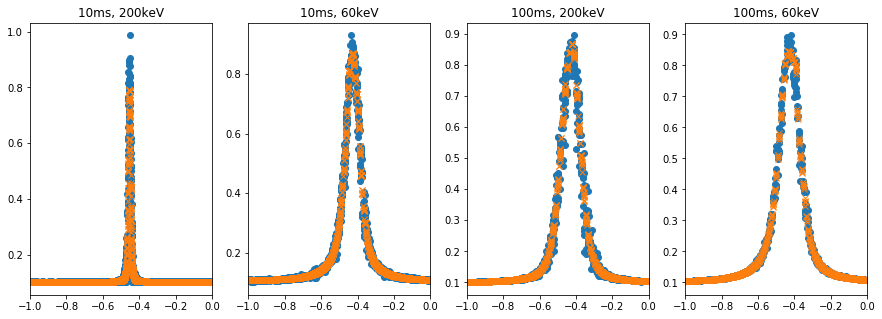

In [160]:
plt.figure(figsize=(15,5))

index10200 = np.where((train_x[:,1] == .1) & (train_x[:,2] == 2))
index1060 = np.where((train_x[:,1] == .1) & (train_x[:,2] == .6))
index100200 = np.where((train_x[:,1] == 1) & (train_x[:,2] == 2))
index10060 = np.where((train_x[:,1] == 1) & (train_x[:,2] == .6))

index10 = np.where(train_x[:,1] == .1)
index100 = np.where(train_x[:,1] == 1)

plt.subplot(141)
plt.title('10ms, 200keV')
plt.xlim([-1,0])
plt.plot(train_x[index10200,0].T, train_y[index10200],'o')
plt.plot(train_x[index10200,0].T, predictions_values[index10200], 'x')
#plt.plot(train_x[index10200,0].T, train_y[index10200],'o')

plt.subplot(142)
plt.xlim([-1,0])
plt.title('10ms, 60keV')
plt.plot(train_x[index1060,0].T, train_y[index1060],'o')
plt.plot(train_x[index1060,0].T, predictions_values[index1060], 'x')

plt.subplot(143)
plt.xlim([-1,0])
plt.title('100ms, 200keV')
plt.plot(train_x[index100200,0].T, train_y[index100200],'o')
plt.plot(train_x[index100200,0].T, predictions_values[index100200], 'x')

plt.subplot(144)
plt.xlim([-1,0])
plt.title('100ms, 60keV')
plt.plot(train_x[index10060,0].T, train_y[index10060],'o')
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x')

plt.show()


Below, the distribution of $\chi^2$ is plotted for training over the $N_{rep}$ MC replicas.

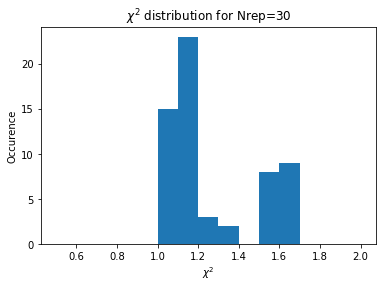

In [162]:
%run Evaluate_pseudodata.ipynb
%run Functions.ipynb
Nrep=30
plt.hist(chi2_array, bins=15, range=[0.5, 2])
plt.title('$\chi^2$ distribution for Nrep=30')
plt.xlabel('$\chi^2$')
plt.ylabel('Occurence')
plt.savefig('Data/Results/%(date)s/aaa chidistribution_%(epoch)s_Nrep=%(i)s' % {"date": d_string, "epoch": training_epochs, "i": Nrep })

plt.show()


## Residuals

In [147]:
N_train = len(train_x[:,0])

best_pred = pseudo_pred[N_train*12 :N_train*13 ]
best_y = pseudo_y[N_train*12 :N_train*13]
train_sigma = train_sigma.reshape(N_train,)

best_res = residuals(best_pred, best_y, train_sigma)

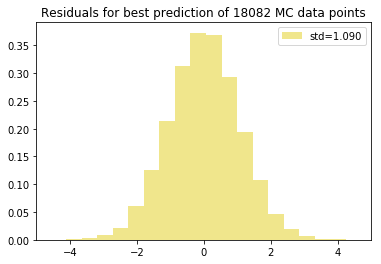

In [148]:
n, bins = np.histogram(best_res, bins=10)

mids = 0.5*(bins[1:] + bins[:-1])
probs = n / np.sum(n)

mean = np.sum(probs * mids)  
sd = np.sqrt(np.sum(probs * (mids - mean)**2))

label1 = 'std=%(std).5s' % {"std":sd}

fig = plt.hist(best_res, bins=20, density=True, color='khaki', label=label1)
plt.title('Residuals for best prediction of %(N_train)s MC data points' % {"N_train": N_train})
plt.legend([label1])

plt.xlim([-5,5])
plt.show()

## Extrapolation in energy loss

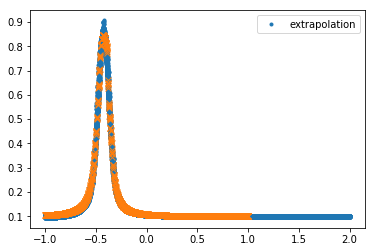

In [224]:
x_extrapol = extrapolation['dE']
prediction = extrapolation['D']
plt.plot(x_extrapol, prediction, '.', label='extrapolation')
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x')

plt.legend()


## Interpolation in Beam Energy

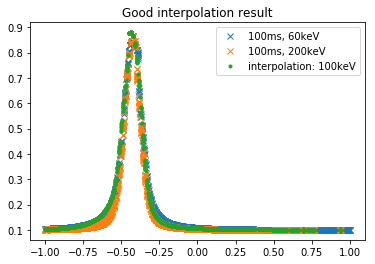

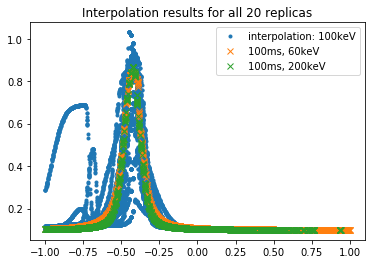

In [230]:
%run Evaluate_pseudodata.ipynb

x_interpol = interpolation['dE']

k=4
prediction_interpol = interpolation['D']
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x', label='100ms, 60keV')
plt.plot(train_x[index100200,0].T, predictions_values[index100200], 'x', label='100ms, 200keV')
plt.plot(x_interpol[k * N_interpol : (k+1)*N_interpol], prediction_interpol[k*N_interpol :(k+1)*N_interpol], '.', label='interpolation: 100keV')
plt.title('Good interpolation result')
plt.legend()
plt.show()

plt.plot(x_interpol, prediction_interpol, '.', label='interpolation: 100keV')
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x', label='100ms, 60keV')
plt.plot(train_x[index100200,0].T, predictions_values[index100200], 'x', label='100ms, 200keV')
plt.title('Interpolation results for all 20 replicas')
plt.legend()
plt.show()


## Write everything to report file

In [157]:
import sys
import base64

energy = 200
time = 10
nbins = 60
training_epochs = 100000

reportname = r'Reports/%(date)s_%(energy)skeV_%(time)sms_e%(epoch)s_Nrep=%(i)s.html' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
sys.stdout = open(reportname,'w')


from prettytable import PrettyTable
list1 = ['Energy:','Exposure time:','Nbins:', 'Replicas:', 'Training epochs:']
list2 = [energy, time, nbins, Nrep, training_epochs]

for x in range(0,5):
    print('%(s1)s %(s2)s <br />' % {"s1": list1[x], "s2": list2[x]}) 



In [ ]:
plot1 = r'Data/Results/%(date)s/aaa chidistribution_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot2 = r'Data/Results/%(date)s/aaa means-vs-means_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot3 = r'Data/Results/%(date)s/aaa std-vs-std_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot4 = r'Data/Results/%(date)s/aaa Residuals_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }

data_uri1 = base64.b64encode(open(plot1, 'rb').read()).decode('utf-8')
data_uri2 = base64.b64encode(open(plot2, 'rb').read()).decode('utf-8')
data_uri3 = base64.b64encode(open(plot3, 'rb').read()).decode('utf-8')
data_uri4 = base64.b64encode(open(plot4, 'rb').read()).decode('utf-8')
img_tag1 = '<img src="data:image/png;base64,{0}">'.format(data_uri1)
img_tag2 = '<img src="data:image/png;base64,{0}">'.format(data_uri2)
img_tag3 = '<img src="data:image/png;base64,{0}">'.format(data_uri3)
img_tag4 = '<img src="data:image/png;base64,{0}">'.format(data_uri4)

print(img_tag1)
print(img_tag2)
print(img_tag3)
print(img_tag4)